In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv
import sys

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
from scipy import special
from scipy.stats import kstwobign, anderson
import scipy.stats.distributions as dist

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full-rem-seps-z.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_cat

,ID,ORyanID_23,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,816891,4000705532455,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,860686,4000705533383,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,1.571297e-06,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,1301188,4000705539941,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,1304538,4000705540034,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,1310001,4000705540064,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-1.023530e-05,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,1520733,4001204758614_extra,stage4,149.891374,2.866981,28107.876953,37826.437500,0.000086,0.000104,-9.313976e-07,...,-9.441206,-9.279022,-9.095134,-9.003501,-8.955496,0.120441,0.213251,0.306832,0.556012,0.731876
3928,1520749,4546055995_extra,stage2,150.383110,2.865367,16320.103516,37787.917969,0.000131,0.000236,7.123858e-05,...,-9.857880,-9.658215,-9.485625,-9.235816,-8.971795,0.162147,0.238640,0.432004,0.592193,0.687256
3929,1523385,4000927318133_extra,stage3,149.789910,2.865132,30540.179688,37782.648438,0.000045,0.000059,1.600747e-05,...,-9.525900,-9.472779,-9.353454,-9.273221,-9.213521,0.262676,0.355466,0.410356,0.489105,0.566003
3930,1524909,4000747939904_extra,stage3,150.450581,2.872371,14702.710938,37956.468750,0.000248,0.000292,7.378556e-06,...,-9.556987,-9.385500,-9.154130,-9.026810,-8.938077,0.153294,0.283249,0.436332,0.600615,0.693621


In [5]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 9.25')

In [6]:
df_noextra = (
    df_red
    .assign(extra_cont = df_red.ORyanID_23.apply(lambda x: 'y' if type(x) == str and 'extra' in x else 'n'))
    .query('extra_cont == "n"')
    .drop(columns = ['extra_cont'])
)

In [7]:
def weight_dist(arrs, bins=None, return_bins=True, renorm=False, compare = 3):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    if len(arrs) < 4:
        print('This has been set up to handle 4 distributions!')
        print('You have not provided four distributions.')
        sys.exit()
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    hists = []
    _, thebins = np.histogram(arrs[3], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    # hists.append(hist1)
    for i in arrs:
        hist_tmp, _ = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hists[0][i_bin]
        count2 = hists[1][i_bin]
        count3 = hists[2][i_bin]
        count4 = hists[3][i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arrs[0] >= b0) & (arrs[0] <= b1)
            in_bin2 = (arrs[1] >= b0) & (arrs[1] <= b1)
            in_bin3 = (arrs[2] >= b0) & (arrs[2] <= b1)
            in_bin4 = (arrs[3] >= b0) & (arrs[3] <= b1)
        else: 
            in_bin1 = (arrs[0] >  b0) & (arrs[0] <= b1)
            in_bin2 = (arrs[1] >  b0) & (arrs[1] <= b1)
            in_bin3 = (arrs[2] >  b0) & (arrs[2] <= b1)
            in_bin4 = (arrs[3] >  b0) & (arrs[3] <= b1)
            
        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0) | (count3 == 0) | (count4 == 0):
            ws_list[0][in_bin1] = 0.0
            ws_list[1][in_bin2] = 0.0
            ws_list[2][in_bin3] = 0.0
            ws_list[3][in_bin4] = 0.0

        elif count1 <= count2 and count1 <= count3 and count1 <= count4:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            ws_list[0][in_bin1] = 1.0
            ws_list[1][in_bin2] = float(count1)/float(count2)
            ws_list[2][in_bin3] = float(count1)/float(count3)
            ws_list[3][in_bin4] = float(count1)/float(count4)
            
        elif count2 <= count1 and count2 <= count3 and count2 <= count4:
            ws_list[0][in_bin1] = float(count2)/float(count1)
            ws_list[1][in_bin2] = 1.0
            ws_list[2][in_bin3] = float(count2)/float(count3)
            ws_list[3][in_bin4] = float(count2)/float(count4)
            
        elif count3 <= count1 and count3 <= count2 and count3 <= count4:
            ws_list[0][in_bin1] = float(count3)/float(count1)
            ws_list[1][in_bin2] = float(count3)/float(count2)
            ws_list[2][in_bin3] = 1.0
            ws_list[3][in_bin4] = float(count3)/float(count4)
            
        elif count4 <= count1 and count4 <= count2 and count4 <= count3:
            ws_list[0][in_bin1] = float(count4)/float(count1)
            ws_list[1][in_bin2] = float(count4)/float(count2)
            ws_list[2][in_bin3] = float(count4)/float(count3)
            ws_list[3][in_bin4] = 1.0
                        
        else:
            print('What the hell happened.')
            print(count1)
            print(count2)
            print(count3)
            print(count4)
            sys.exit()

        # else:
        #     # weight count1 values so the sum of wt1 in this bin equals count2
        #     # wt_fac will always be <= 1
        #     wt_fac = float(count2)/float(count1)
        #     ws_list[compare][in_bin1] = wt_fac
        #     ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws_list, thebins 
    else: 
        return ws_list

In [8]:
masses_s1 = np.array(df_red.query('category == "stage1"')['lp_mass_best'])
masses_s2 = np.array(df_red.query('category == "stage2"')['lp_mass_best'])
masses_s3 = np.array(df_red.query('category == "stage3"')['lp_mass_best'])
masses_s4 = np.array(df_red.query('category == "stage4"')['lp_mass_best'])

In [9]:
sfr_s1 = np.array(df_red.query('category == "stage1"')['ez_sfr'])
sfr_s2 = np.array(df_red.query('category == "stage2"')['ez_sfr'])
sfr_s3 = np.array(df_red.query('category == "stage3"')['ez_sfr'])
sfr_s4 = np.array(df_red.query('category == "stage4"')['ez_sfr'])

In [10]:
weights, thebins = weight_dist([masses_s1, masses_s2, masses_s3, masses_s4], bins = 15, renorm = False, return_bins = True, compare = 3)
# weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
# weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

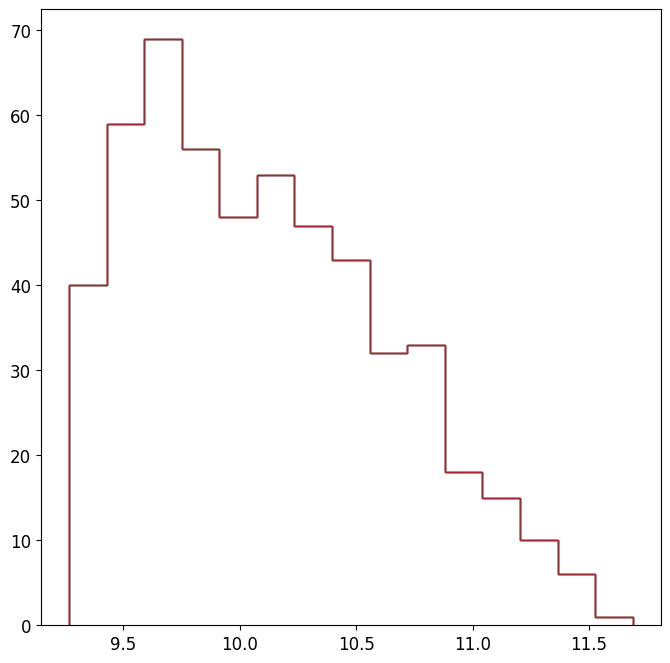

In [11]:
plt.figure(figsize = (8,8))
plt.hist(masses_s1, bins = thebins, weights=weights[0], histtype = 'step', color = 'black')
plt.hist(masses_s2, bins = thebins, weights=weights[1], histtype = 'step', color = 'blue')
plt.hist(masses_s3, bins = thebins, weights=weights[2], histtype = 'step', color = 'orange')
plt.hist(masses_s4, bins = thebins, weights=weights[3], histtype = 'step', color = 'brown')
plt.show()

In [12]:
masses = [masses_s1, masses_s2, masses_s3, masses_s4]
sfrs = [sfr_s1, sfr_s2, sfr_s3, sfr_s4]

## Calculating the Errors

In [13]:
def lower_beta(c,k,n):
    return dist.beta.ppf((1-c)/2, k+1, n-k+1)

In [14]:
def upper_beta(c,k,n):
    return dist.beta.ppf(1-(1-c)/2, k+1, n-k+1)

In [15]:
p_masses = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    mass_stage = masses[counter]    
    # Getting Confidence Interval
        
    _, bins = np.histogram(mass_stage, bins=thebins)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(mass_stage > lower_bin) & (mass_stage <= upper_bin)][0].astype(bool)
        
        mass_bin = mass_stage[mask]
        
        counts = len(mass_bin)
        
        upper_p = upper_beta(0.683, counts, len(mass_stage))
        lower_p = lower_beta(0.683, counts, len(mass_stage))
                        
        if counts == 0:
            p_masses[counter].append([0,0])
        else:
            p_masses[counter].append([ (counts / len(mass_stage)) - lower_p,  upper_p - (counts / len(mass_stage))])

In [16]:
p_sfrs = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    sfr_stage = sfrs[counter]    
    # Getting Confidence Interval
        
    _, bins = np.histogram(sfr_stage, bins=thebins_sfr)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(sfr_stage > lower_bin) & (sfr_stage <= upper_bin)][0].astype(bool)
        
        sfr_bin = sfr_stage[mask]
        
        counts = len(sfr_bin)
        
        upper_p = upper_beta(0.683, counts, len(sfr_stage))
        lower_p = lower_beta(0.683, counts, len(sfr_stage))
                        
        if counts == 0:
            p_sfrs[counter].append([0,0])
        else:
            p_sfrs[counter].append([ (counts / len(sfr_stage)) - lower_p,  upper_p - (counts / len(sfr_stage))])

NameError: name 'thebins_sfr' is not defined

## Plotting

In [20]:
colours = ['blue','black','orange','purple']
linestyles = ['solid', 'dotted','dashed','dashdot']

In [21]:
_, thebins_sfrs = weight_dist(sfrs, bins = 15, renorm = False, return_bins = True, compare = 3)

NameError: name 'p_sfr' is not defined

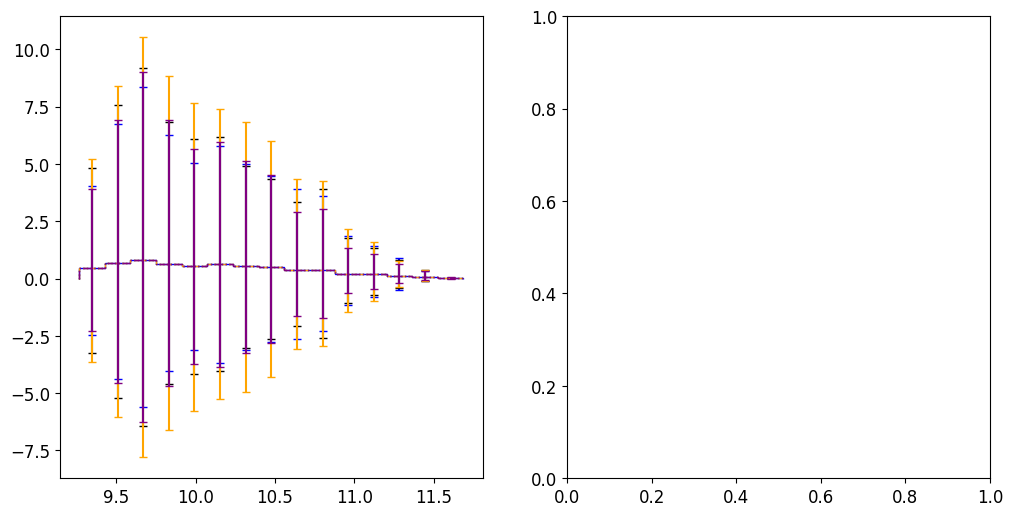

In [22]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
for p in range(2):
    if p == 0:
        for i in range(4):
            bin_counts, bins = np.histogram(masses[i], bins = thebins, weights=weights[i], density = True)
            bincenters = 0.5 * (bins[1:] + bins[:-1])

            error_array = np.asarray(p_masses[i]).T

            ax[0].hist(masses[i], bins = thebins, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i], density = True)
            ax[0].errorbar(bincenters, (bin_counts), yerr= bin_counts * error_array, linestyle = '', color=colours[i], barsabove=True, capsize=3)
    elif p == 1:
        for i in range(4):
            bin_counts, bins = np.histogram(sfrs[i], bins = thebins_sfrs, weights=weights[i], density = True)
            bincenters = 0.5 * (bins[1:] + bins[:-1])

            error_array = np.asarray(p_sfr[i]).T

            ax[1].hist(sfrs[i], bins = thebins_sfrs, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i], density = True)
            ax[1].errorbar(bincenters, bin_counts, yerr= error_array, linestyle = '', color=colours[i], capsize = 3)

ax[0].set_xlim([9.1,12.1])
# ax[0].set_ylim([0,0.12])
# ax[1].set_ylim([0,0.32])
ax[1].set_xlim([-3,3])
ax[1].legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper left', fontsize = 12)
# plt.ylim([0, 1.10])
ax[0].set_xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
ax[1].set_xlabel('$\log$(SFR (M$_\odot$ yr$^{-1}$))', fontsize = 14)
ax[0].set_ylabel('Weighted N Classifications', fontsize = 14)
ax[0].tick_params(left = False, labelleft=False)
ax[1].tick_params(left = False, labelleft=False)
fig.tight_layout()
# fig.savefig(f'{fig_folder}/mass_sfr_dist_comb.pdf', bbox_inches = 'tight', dpi = 720)
plt.show()

## Using Poisson Statistics

In [35]:
p_masses = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    mass_stage = masses[counter]
    weights_stage = weights[counter]
    # Getting Confidence Interval
        
    _, bins = np.histogram(mass_stage, bins=thebins)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(mass_stage > lower_bin) & (mass_stage <= upper_bin)][0].astype(bool)
        
        mass_bin = mass_stage[mask]
        weights_bin = weights_stage[mask]
                
        counts = np.sum(weights_bin * np.ones(len(mass_bin)))
                
        upper = counts + (1 * np.sqrt(counts + 1)) + ((1**2 + 2)/3)
        lower = counts - (1 * np.sqrt(counts)) + ((1*2 - 1) / 3)
                        
        if counts == 0:
            p_masses[counter].append([0,0])
        else:
            p_masses[counter].append([counts - lower,  upper - counts])

In [36]:
p_sfrs = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    sfr_stage = sfrs[counter]
    weights_stage = weights[counter]
    # Getting Confidence Interval
        
    _, bins = np.histogram(sfr_stage, bins=thebins_sfrs)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(sfr_stage > lower_bin) & (sfr_stage <= upper_bin)][0].astype(bool)
        
        sfr_bin = sfr_stage[mask]
        weights_bin = weights_stage[mask]
                
        counts = np.sum(weights_bin * np.ones(len(sfr_bin)))
                
        interval = poisson_conf_interval(counts, interval = 'root-n')
                        
        if counts == 0:
            p_sfrs[counter].append([0,0])
        else:
            p_sfrs[counter].append([counts - interval[0],  interval[1] - counts])

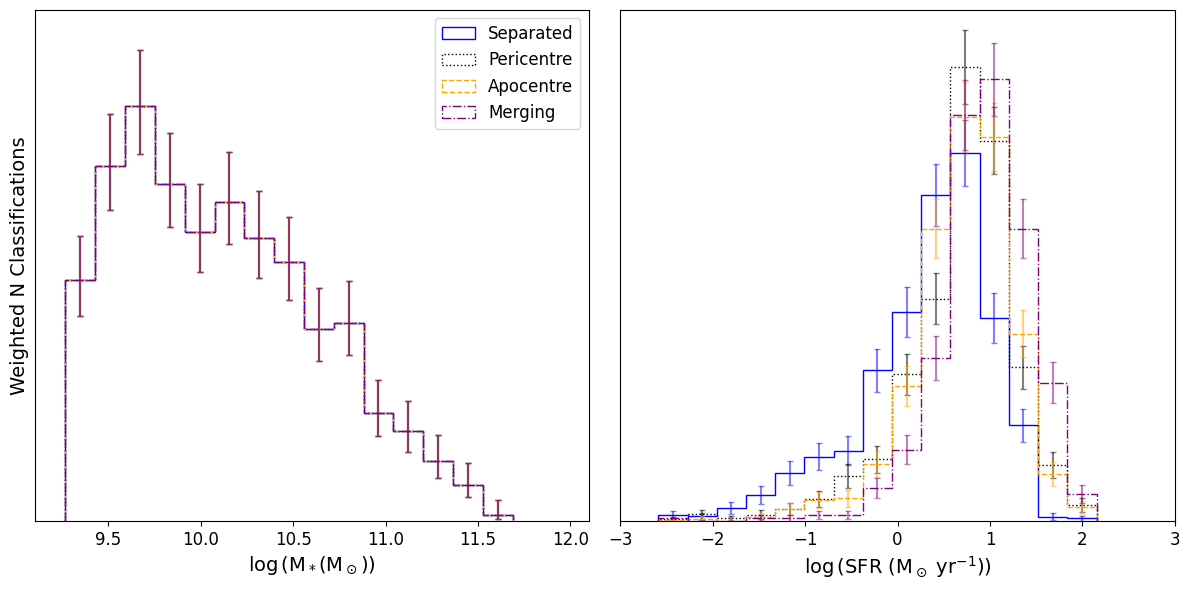

In [37]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
for p in range(2):
    if p == 0:
        for i in range(4):
            bin_counts, bins = np.histogram(masses[i], bins = thebins, weights=weights[i])
            bincenters = 0.5 * (bins[1:] + bins[:-1])

            error_array = np.asarray(p_masses[i]).T

            ax[0].hist(masses[i], bins = thebins, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i])
            ax[0].errorbar(bincenters, (bin_counts), yerr= error_array, linestyle = '', color=colours[i], barsabove=True, capsize=2, alpha = 0.5)
    elif p == 1:
        for i in range(4):
            bin_counts, bins = np.histogram(sfrs[i], bins = thebins_sfrs, weights=weights[i])
            bincenters = 0.5 * (bins[1:] + bins[:-1])

            error_array = np.asarray(p_sfrs[i]).T

            ax[1].hist(sfrs[i], bins = thebins_sfrs, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i])
            ax[1].errorbar(bincenters, bin_counts, yerr= error_array, linestyle = '', color=colours[i], capsize = 2, alpha = 0.5)

ax[0].set_xlim([9.1,12.1])
ax[0].set_ylim([0,85])
ax[1].set_ylim([0,170])
ax[1].set_xlim([-3,3])
ax[0].legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper right', fontsize = 12)
# plt.ylim([0, 1.10])
ax[0].set_xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
ax[1].set_xlabel('$\log$(SFR (M$_\odot$ yr$^{-1}$))', fontsize = 14)
ax[0].set_ylabel('Weighted N Classifications', fontsize = 14)
ax[0].tick_params(left = False, labelleft=False)
ax[1].tick_params(left = False, labelleft=False)
fig.tight_layout()
fig.savefig(f'{fig_folder}/mass_sfr_dist_comb.pdf', bbox_inches = 'tight', dpi = 720)
plt.show()

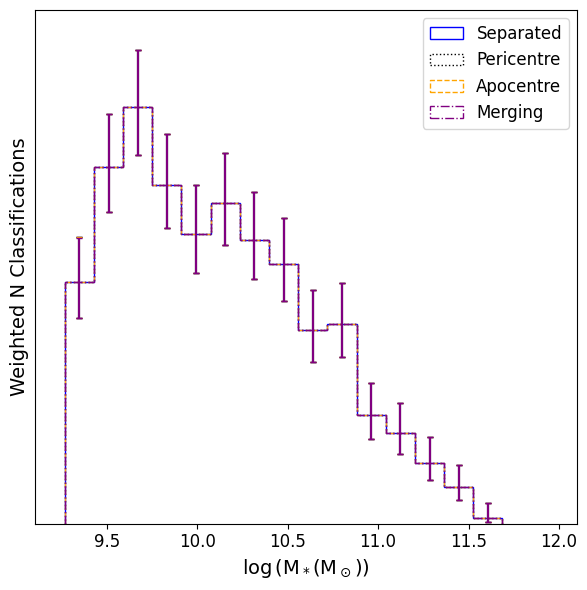

In [40]:
fig, ax = plt.subplots(ncols = 1, figsize = (6,6))
for i in range(4):
    bin_counts, bins = np.histogram(masses[i], bins = thebins, weights=weights[i])
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    error_array = np.asarray(p_masses[i]).T

    ax.hist(masses[i], bins = thebins, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i])
    ax.errorbar(bincenters, (bin_counts), yerr= error_array, linestyle = '', color=colours[i], barsabove=True, capsize=2)
ax.set_xlim([9.1,12.1])
ax.set_ylim([0,85])
ax.legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper right', fontsize = 12)
# plt.ylim([0, 1.10])
ax.set_xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
ax.set_ylabel('Weighted N Classifications', fontsize = 14)
ax.tick_params(left = False, labelleft=False)
# ax[1].tick_params(left = False, labelleft=False)
fig.tight_layout()
fig.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight', dpi = 720)
plt.show()

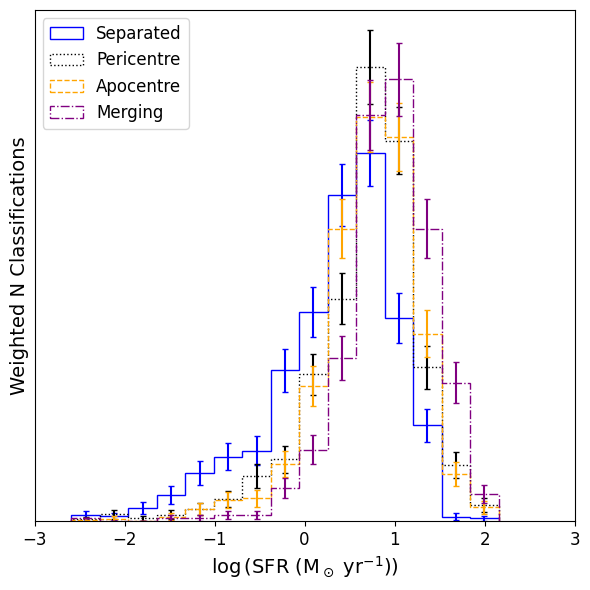

In [41]:
fig, ax = plt.subplots(ncols = 1, figsize = (6,6))
for i in range(4):
    bin_counts, bins = np.histogram(sfrs[i], bins = thebins_sfrs, weights=weights[i])
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    error_array = np.asarray(p_sfrs[i]).T

    ax.hist(sfrs[i], bins = thebins_sfrs, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i])
    ax.errorbar(bincenters, bin_counts, yerr= error_array, linestyle = '', color=colours[i], capsize = 2)
    
ax.set_ylim([0,170])
ax.set_xlim([-3,3])
ax.legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper left', fontsize = 12)
# plt.ylim([0, 1.10])
# ax[0].set_xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
ax.set_xlabel('$\log$(SFR (M$_\odot$ yr$^{-1}$))', fontsize = 14)
ax.set_ylabel('Weighted N Classifications', fontsize = 14)
# ax[0].tick_params(left = False, labelleft=False)
ax.tick_params(left = False, labelleft=False)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr_dist.pdf', bbox_inches = 'tight', dpi = 720)
plt.show()